## Libraries import

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

## Helper Functions

We will define a helper function, ```show_data``` to plot the images individually from the Fashion Dataset. The raw images from the dataset which can also be resized, are 28px height and 28px wide.

In [2]:
IMAGE_SIZE = 28

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

## Dataset Handling

During this project we'll be working with the MNIST Fashion dataset, a well know dataset which happens to come together as a toy example within the pytorch library.

The Fashion-MNIST dataset is proposed as a more challenging replacement dataset for the MNIST dataset. It is a dataset comprised of 60,000 small square 28×28 pixel grayscale images of items of 10 types of clothing, such as shoes, t-shirts, dresses, and more.

We're not going to rescale the images, since we want to increase the prediction performance at the cost of a higher training time. Hence, the only transformation taking place will be the one needed to handle images as Tensor objects (matrices).

In [3]:
# transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
train_dataset = dsets.FashionMNIST(root='./data/', train=True, download=True, transform=transform)
validation_dataset = dsets.FashionMNIST(root='./data/', train=False, download=True, transform=transform)

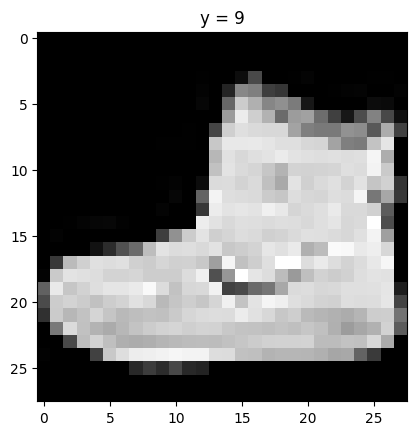

In [5]:
show_data(train_dataset[0])

## Building the Model

It's known that Convolutional Neural Networks (CNN) are one of the most used architectures for Computer Vision. This kind of architectures can achieve impressive results generally in the range of 90% accuracy. Not only that, the models tend to generalize well.

A CNN is composed of several steps consisting of convolutions and activations. Several layers can be piped together to enhace the feature extraction (yeap we feed the model with raw data). Generally, we use convolutions as a way to reduce the amount of information while keeping the features intact. This helps us reduce the amount of inputs (and neurons) in the last layer. Here is a good resource in case you want a deeper understanding [CNN Cheatsheet CS 230](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks) in this topics. For this particular case we'll use a convolution with a kernel of size 5 and a Max Pool activation with size 2.

If you're new to convolutions, here's also a good video which shows in the first minutes how the convolution takes place. It's a good animation which help us visualize the concept [How convolution works](https://www.youtube.com/watch?v=8rrHTtUzyZA). Furthermore, in case you want to know more about Max Pool activations, here's another video with explanations [Max Pooling](https://www.youtube.com/watch?v=ZjM_XQa5s6s). Important to say is that the convolution kernel (or filter) weights (parameters) will be learned during the training, in order to optimize the model.

One of the hardest parts of designing the model is determining the inputs of the last linear layer. The last layer helps us determine the predicted classes or labels, in this case the different clothing categories included in the dataset.

<img src="img/2layersCNN.png" alt="2 Layer CNN" width="800"/>

We'll create a 2-layer CNN with a Max Pool activation function piped to the convolution result. Since we don´t want to loose the images edges, we'll add padding to the images before the convolution takes place. During the whole project we'll be working with square matrices where m=n (rows are equal to columns). We will refer to the matrix input dimension as ```I```, where in this particular case ```I = 28``` for the raw images. In the same way, the dimension of the output matrix will be represented with letter ```O```

### Convolution parameters

- ```kernel = 5```
- ```padding = 2```
- ```stride = 1```
- ```dilation = 1```

Given this parameters, the new matrix dimension after the convolution process is:

```O = I + 2 * p - k + 1```

```O = I```

where:
- p: padding
- k: kernel size
- I: Input matrix size
- O: Output matrix size

### MaxPool Activation parameters
For the MaxPool activation, stride is by default the size of the kernel. Parameters are:

- ```kernel = 2```
- ```padding = 0```
- ```stride = 2```
- ```dilation = 1```

Given this parameters, the new matrix dimension after the Max Pool activation are:

```O = (I - k)/s + 1```

```O = (I - 2)/2 + 1```

```O = I/2```

If you're interested in determining the matrix dimension after the several filtering processes, you can also check it out in this:
[CNN Cheatsheet CS 230](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)
### Actual project matrix dimensions
After the previous discussion, in this particular case, the project matrix dimensions are the following

- After the first convolution, the output matrices have a dimension of 28x28 px.
- The dimension of the matrices after the Max Pool activation are 14x14 px.
- The resultant matrices after the second convolution, with the same kernel and padding as the fist one, are 14x14 px.
- Finally after the last Max Pool activation, the resultant matrices have a dimension of 7x7 px.

We'll use the last Max Pool activation output matrix to dimension the amount of inputs of the fully connected layer.

The following class shows a ```forward``` method, where we define how the operations will be organized inside the model. This is, here is where we describe the architecture type we would like to create. PyTorch offers an alternative way to this called the ```Sequential``` mode. You can learn more [here](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). As you may notice, the first transformation is a convolution, followed by a Relu activation and later a MaxPool Activation/Transformation. As mentioned before, the result tends to be a feature extraction process, in order to preserve predictors and process less information by the last neuron's layer.

In [6]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32, out_mp2=7*7):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * out_mp2, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        # Flatten the matrices
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [7]:
# out_1: amount of output channels of the first convolution
# out_2:                                  second
# out_mp2: matrix dimension after the second max pool activation
model = CNN(out_1=16, out_2=32, out_mp2=7*7)

## Determining Optimizer and Data Loader
After modelling our Neural Network, we have to determine the loss function and optimizations parameters. For so, we'll select a Cross Entropy strategy as the loss function. This kind of strategy for loss determination is what we typically choose with non-binary categorical variables. There's a great article to learn more about it [here](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e). To determine the minimum loss we'll use a Stochastic Gradient Descent strategy, which is almost plain vainilla style in those cases where our data doesn't fit in memory, so the gradient is determined with batches and several steps. For this purpose, we'll create the ```train_loader``` and ```validation_loader``` iterators.

In [8]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

## Training the Model

We're gonna run some training iterations (epochs) through the data, this will be done in several batches. Then we're gonna check the accuracy of the model with the validation data, finally we'll repeat the process. Important to see that ```optimizer.step()``` adjusts the model weights for the next iteration, this is to minimize the error with the true function ```y```.

Finally we'll append the cost and accuracy value for each epoch and plot the final results. Probably, we'll see how the cost descends and accuracy increases as the model adjusts the weights and "learns" from the training data.

In [9]:
# Train the model

n_epochs=6
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     

train_model(n_epochs)

## Analyzing the Results

Below you'll find the plots with the cost and accuracy for the model. As expected, the cost decrease and the accuracy increases while the model fine-tunes the kernel and linear layer weights. In other words, the model "learns" from the iterations.

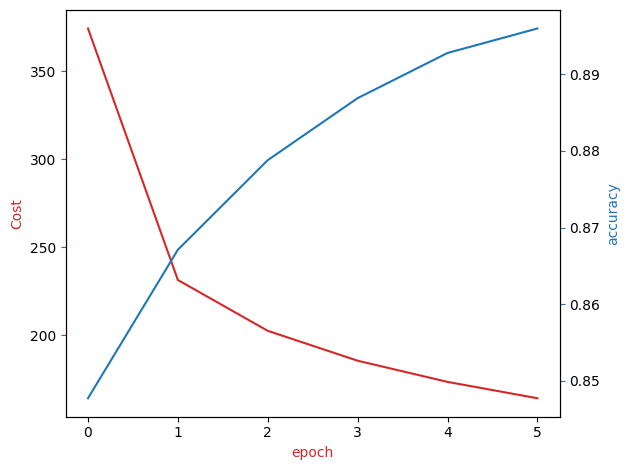

In [10]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

## Checking Classifications

Here's an image depicting the different categories in the Fashion MNIST dataset.

<img src="img/fashion_mnist_classes.png" alt="Fashion MNIST categories" width="800"/>

Finally, we'll check some samples where the model didn't classify the categories correctly. As you may see, sometimes it's not easy to distinguish between a sandal or a sneaker with such a low resolution picture, even for the human eye. Notice also the first image, where the model predicted a bag but it was an ankle boot. It kind of looks like a bag isn't it?. The model also have hard times discriminating pullovers from coats, but with that image, honestly it's hard to tell.



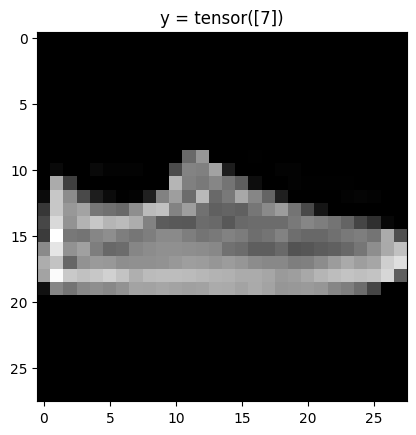

yhat:  tensor([5])


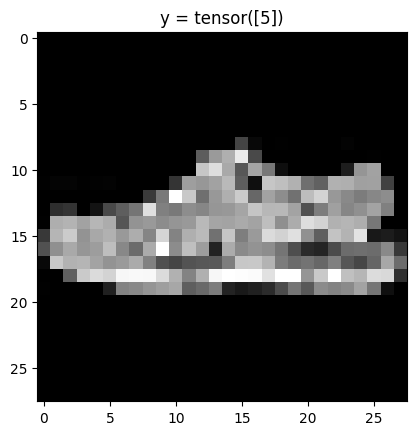

yhat:  tensor([7])


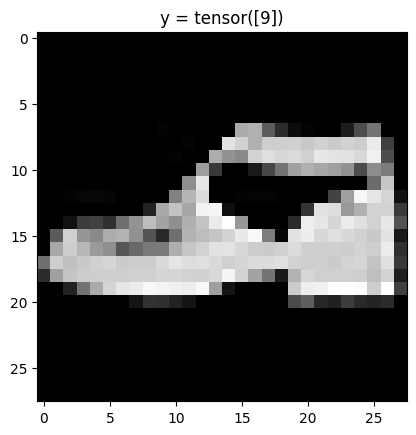

yhat:  tensor([5])


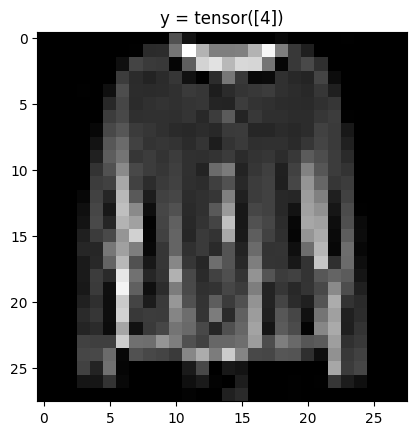

yhat:  tensor([2])


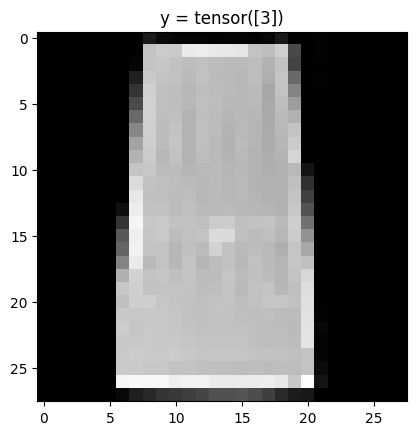

yhat:  tensor([6])


In [11]:
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
        if count >= 5:
            break  

## Wrapping it up

A 2 layer CNN does an excellent work in predicting images from the Fashion MNIST dataset with an overall accuracy after 6 training epochs of almost a 90%. This is not a surprise since this kind of neural network architecture achieve great results.

Certainly, the accuracy can increase reducing the convolution kernel size in order to loose less data per iteration, at the expense of higher training times. Also, normalization can be implemented after each convolution and in the final fully connected layer. This helps achive a larger accuracy in fewer epochs. You can try experimenting with it and leave some comments with the results. There's a good article to learn more about [batch normalization](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd) you can dig in.

In [12]:
torch.save(model, ")

TypeError: save() missing 1 required positional argument: 'f'